In [ ]:
!git clone https://github.com/tulane-cmps6730/project-legal.git

Cloning into 'project-legal'...
remote: Enumerating objects: 998, done.
remote: Counting objects: 100% (998/998), done.
remote: Compressing objects: 100% (504/504), done.
remote: Total 998 (delta 512), reused 947 (delta 476), pack-reused 0
Receiving objects: 100% (998/998), 6.97 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (512/512), done.


In [ ]:
!pip install -r project-legal/requirements.txt

  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached aiohttp-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl (27 kB)
  Using cached blinker-1.7.0-py3-none-any.whl (13 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)
  Using cached comm-0.2.2-py3-none-any.whl (7.2 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
  Using cached cssselect-1.2.0-py2.py3-none-any.whl (18 kB)
  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
  Using cached debugpy-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached evaluate-0.4.1-py3-none-any.whl (84 kB)
  Using cached exceptiongroup-1.2.0-py3-none-any.whl (16 kB)
  Using cached executing-2.0.1-py2.py3-none-any.whl (24 kB)
  Using cached fake_useragent

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.6 MB/s eta 0:00:00
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Experiments

Let's start playing around with our data

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification,AutoModel,AutoConfig
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from imblearn.under_sampling import RandomUnderSampler
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read in training data
This dataset contains 100 annotated terms of service contracts, each row represents a sentence, which carries on it a label. The label corresponds to a different type of potential unfairness, as defined by the authors of CLAUDETTE, the previous paper from which this dataset came from.

In [ ]:
df = pd.read_csv('project-legal/data/dataset.csv')
df.head()

,Unnamed: 0,A,CH,CR,J,LAW,LTD,PINC,TER,USE,document,document_ID,label,text,TER_targets,LTD_targets,A_targets,CH_targets,CR_targets
0,0,0,0,0,0,0,0,0,0,0,Mozilla,0,0,websites & communications terms of use,NaN,NaN,NaN,NaN,NaN
1,1,0,0,0,0,0,0,0,0,0,Mozilla,0,0,please read the terms of this entire document ...,NaN,NaN,NaN,NaN,NaN
2,2,0,0,0,0,0,0,0,0,1,Mozilla,0,1,by accessing or signing up to receive communic...,NaN,NaN,NaN,NaN,NaN
3,3,0,0,0,0,0,0,0,0,0,Mozilla,0,0,our websites include multiple domains such as ...,NaN,NaN,NaN,NaN,NaN
4,4,0,0,0,0,0,0,0,0,0,Mozilla,0,0,you may also recognize our websites by nicknam...,NaN,NaN,NaN,NaN,NaN


Before we were trying binary classification, which wasn't producing great results, let's see if we can get better results using the individual types of labels as classified by the text. The logic here is that because each type of potential unfairness likely has some semantic differences, conglomerating them all into one made it difficult to pick them all out.

# Multi-Label Preprocessing

In [ ]:
df['labels'] = df.apply(lambda row: (1 if row['A'] == 1 else 2 if row['CH'] == 1 else 3 if row['CR'] == 1 else 4 if row['J'] == 1 else 5 if row['LAW'] == 1 else 6 if row['LTD'] == 1 else 7 if row['PINC'] == 1 else 8 if row['TER'] == 1 else 9 if row['USE'] == 1 else 0),axis=1)
x_multi = df['text']
y_multi = df['labels']
df['labels'].value_counts(normalize=True)

labels
0    0.893324
6    0.029681
2    0.016849
8    0.015085
9    0.011853
3    0.010286
4    0.006661
5    0.006122
1    0.005192
7    0.004947
Name: proportion, dtype: float64

In [ ]:
label2id = {
    'FAIR':0,
    'A':1,
    'CH':2,
    'CR':3,
    'J':4,
    'LAW':5,
    'LTD':6,
    'PINC':7,
    'TER':8,
    'USE':9
}
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'FAIR',
 1: 'A',
 2: 'CH',
 3: 'CR',
 4: 'J',
 5: 'LAW',
 6: 'LTD',
 7: 'PINC',
 8: 'TER',
 9: 'USE'}

# Binary Label Pre-Processing

In [ ]:
x, y = df['text'], df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=.8)
x_train_res, y_train_res = rus.fit_resample(pd.DataFrame(x_train), pd.DataFrame(y_train))

In [ ]:
y_train_res.value_counts()

label
0        2162
1        1730
Name: count, dtype: int64

In [ ]:
train_df = pd.merge(x_train_res,y_train_res,left_index=True,right_index=True)
test_df = pd.merge(x_test,y_test,left_index=True,right_index=True)
val_df = pd.merge(x_val,y_val,left_index=True,right_index=True)
train_df = train_df.sample(frac=1)
subset_df = train_df.sample(50)
test_subset_df = test_df.sample(50)

In [ ]:
dataset_dict = DatasetDict(
    {
    "train":Dataset.from_pandas(train_df),
    "test":Dataset.from_pandas(test_df),
    "val":Dataset.from_pandas(val_df),
    "train_subset":Dataset.from_pandas(subset_df),
    "test_subset":Dataset.from_pandas(test_subset_df)
    }
)

Split dataset into train, test and validation

In [ ]:
tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
def tokenize(batch):
    return tokenizer(batch['text'], max_length=512,padding='max_length')

In [ ]:
tokenized_dict = dataset_dict.map(tokenize, batched=True, batch_size=len(dataset_dict))
tokenized_dict.set_format('torch', columns=['input_ids', 'attention_mask',"token_type_ids",'label'])

Map:   0%|          | 0/3892 [00:00<?, ? examples/s]

Map:   0%|          | 0/2042 [00:00<?, ? examples/s]

Map:   0%|          | 0/2042 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Now let's construct a custom classifier classifier to classify sentences as potentially unfair or not

In [ ]:
class Classifier_v1(nn.Module):
    def __init__(self, model_name):
        super(Classifier_v1,self).__init__()
        self.model = AutoModel.from_pretrained(model_name,config = AutoConfig.from_pretrained(model_name,
                                                                                              output_attention = True,
                                                                                              output_hidden_state = True))
        # New Layer
        self.dropout = nn.Dropout(0.1)
        self.hidden = nn.Linear(self.model.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, input = None, attention_mask = None, token_type_ids = None,input_ids = None, labels = None):
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        pooler_output = outputs.pooler_output[0]
        output = self.hidden(pooler_output)
        logit = self.sigmoid(output)
        return logit

In [ ]:
from torch.utils.data import DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dict['train'], shuffle=True, batch_size=1, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_dict['test'], shuffle=True, batch_size=1,collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_dict['val'], shuffle=True, batch_size=1,collate_fn=data_collator
)
train_subset_dataloader = DataLoader(
    tokenized_dict['train_subset'], shuffle=True, batch_size=1,collate_fn=data_collator
)
test_subset_dataloader = DataLoader(
    tokenized_dict['test_subset'], shuffle=True, batch_size=1,collate_fn=data_collator
)

## Training Loop

In [ ]:
torch.cuda.empty_cache()

# Full Loop

In [ ]:
def train(model,train_dataloader,test_dataloader,epochs,loss_fn,optimizer,num_train_samples,num_test_samples,lr_scheduler=None,testing=False):
    for epoch in range(epochs):
        model.train()
        train_labels = []
        train_preds = []
        train_loss = 0
        for batch in tqdm.tqdm(train_dataloader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch['labels'].to(torch.float32).to(device)
            output = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
            loss = loss_fn(output[0],label)
            train_loss += loss.item()
            pred = torch.round(output[0])
            train_preds.append(pred.detach().cpu().numpy())
            train_labels.append(label.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if lr_scheduler:
                lr_scheduler.step(loss)
        print(f"Train Epoch: {epoch + 1} | Accuracy: {accuracy_score(train_labels,train_preds)} | Precision: {precision_score(train_labels,train_preds)} | Recall: {recall_score(train_labels,train_preds)} | F1: {f1_score(train_labels,train_preds)} | Loss: {train_loss/num_train_samples}")
        if testing:
            preds = []
            labels = []
            test_loss = 0
            for i,batch in tqdm.tqdm(enumerate(test_dataloader)):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                label = batch['labels'].to(torch.float32).to(device)
                with torch.no_grad():
                    output = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
                loss = loss_fn(output[0],label)
                test_loss += (loss.item())
                pred = torch.round(output[0])
                preds.append(pred.detach().cpu().numpy())
                labels.append(batch["labels"].detach().cpu().numpy())
            print(f"Test Epoch: {epoch + 1} | Accuracy: {accuracy_score(labels,preds)} | Precision: {precision_score(labels,preds)} | Recall: {recall_score(labels,preds)} | F1: {f1_score(labels,preds)} | Loss: {test_loss/num_test_samples}")

In [ ]:
def test(model,test_dataloader,loss_fn):
    model.eval()
    preds = []
    labels = []
    for i,batch in tqdm.tqdm(enumerate(test_dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        label = batch['labels'].to(torch.float32).to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
        loss = loss_fn(output,label)
        pred = torch.round(output)
        preds.append(pred.detach().cpu().numpy()[0])
        labels.append(batch["labels"].detach().cpu().numpy())
    print(f"Accuracy: {accuracy_score(labels,preds)} | Precision: {precision_score(labels,preds)} | Recall: {recall_score(labels,preds)} | F1: {f1_score(labels,preds)} | Loss: {loss}")
    return preds,labels

Looking much better than before, but there is still a lot of room for improvement

This is not working, even with oversampling we are still not getting good results. I think the problem is that the pooler output, which is the (mean?) of all the 12 hidden states of BERT that we are using as input to our additional classifier is not capturing the information we need to understand the fairness of a sentence. Instead of using the pooler output, let's use a concatenation of all the hidden states of the BERT model

In [ ]:
class Classifier_V2(nn.Module):
    '''
    This model is similar to the first one but instead of using the pooler output, it uses the hidden states of the model
    The 'hidden_states_used' parameter is used to determine how many hidden states to use, smaller values of this will be less computationally expensive, but likely less accurate
    '''
    def __init__(self, model_name ,num_labels,hidden_states_used):
        super(Classifier_V2,self).__init__()
        self.hidden_states_used = hidden_states_used
        self.model = BertModel.from_pretrained(model_name,config = BertConfig.from_pretrained(model_name,output_hidden_states = True,num_labels=num_labels))
        self.hidden1 = nn.Linear(self.model.config.hidden_size*self.model.config.max_position_embeddings*self.hidden_states_used, 64)
        self.hidden_p = nn.Linear(self.model.config.hidden_size, 64)
        self.fc = nn.Linear(64, num_labels)
        self.dropout = nn.Dropout(0.1)
        if num_labels == 1:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)

    def forward(self, attention_mask = None, token_type_ids = None,input_ids = None):
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        hidden_states = torch.cat(outputs.hidden_states[-self.hidden_states_used:],dim=0).view(1,-1)
        pooler_output = outputs.pooler_output
        x_pooler = self.hidden_p(self.dropout(pooler_output))
        x_hidden = self.hidden1(self.dropout(hidden_states))
        x = torch.add(x_pooler,x_hidden)
        output = self.fc(x)
        logit = self.activation(output)
        return logit


In [ ]:
loss_fn = nn.BCELoss()
model_v2 = Classifier_V2('nlpaueb/legal-bert-base-uncased',1,6).to(device)
optimizer = Adam(model_v2.parameters(),lr =.0000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=2,patience=3)

In [ ]:
train(model_v2,train_subset_dataloader,test_subset_dataloader,10,loss_fn,optimizer,num_train_samples=50,num_test_samples=50,testing=True)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


Train Epoch: 1 | Accuracy: 0.42 | Precision: 0.35294117647058826 | Recall: 0.25 | F1: 0.2926829268292683 | Loss: 0.7563589495420456


50it [00:12,  3.90it/s]


Test Epoch: 1 | Accuracy: 0.86 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 | Loss: 0.5644528120756149


100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Train Epoch: 2 | Accuracy: 0.62 | Precision: 0.8571428571428571 | Recall: 0.25 | F1: 0.3870967741935484 | Loss: 0.6564678603410721


50it [00:12,  4.01it/s]


Test Epoch: 2 | Accuracy: 0.66 | Precision: 0.125 | Recall: 0.4 | F1: 0.19047619047619047 | Loss: 0.6509701585769654


100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Train Epoch: 3 | Accuracy: 0.74 | Precision: 0.6666666666666666 | Recall: 0.9166666666666666 | F1: 0.7719298245614035 | Loss: 0.6002006658911705


50it [00:12,  3.87it/s]


Test Epoch: 3 | Accuracy: 0.68 | Precision: 0.13333333333333333 | Recall: 0.4 | F1: 0.2 | Loss: 0.6116728174686432


100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Train Epoch: 4 | Accuracy: 0.82 | Precision: 0.8571428571428571 | Recall: 0.75 | F1: 0.8 | Loss: 0.5769010004401207


50it [00:12,  4.15it/s]


Test Epoch: 4 | Accuracy: 0.86 | Precision: 0.25 | Recall: 0.2 | F1: 0.2222222222222222 | Loss: 0.5089388361573219


100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


Train Epoch: 5 | Accuracy: 0.76 | Precision: 0.875 | Recall: 0.5833333333333334 | F1: 0.7 | Loss: 0.5542890709638596


50it [00:13,  3.83it/s]


Test Epoch: 5 | Accuracy: 0.76 | Precision: 0.1111111111111111 | Recall: 0.2 | F1: 0.14285714285714285 | Loss: 0.5196777975559235


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Train Epoch: 6 | Accuracy: 0.92 | Precision: 0.9166666666666666 | Recall: 0.9166666666666666 | F1: 0.9166666666666666 | Loss: 0.4833053112030029


50it [00:13,  3.77it/s]


Test Epoch: 6 | Accuracy: 0.72 | Precision: 0.23529411764705882 | Recall: 0.8 | F1: 0.36363636363636365 | Loss: 0.5877727711200714


100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Train Epoch: 7 | Accuracy: 0.92 | Precision: 0.9545454545454546 | Recall: 0.875 | F1: 0.9130434782608695 | Loss: 0.44663905635476114


50it [00:13,  3.82it/s]


Test Epoch: 7 | Accuracy: 0.68 | Precision: 0.13333333333333333 | Recall: 0.4 | F1: 0.2 | Loss: 0.5622653564810753


100%|██████████| 50/50 [01:22<00:00,  1.64s/it]


Train Epoch: 8 | Accuracy: 0.92 | Precision: 1.0 | Recall: 0.8333333333333334 | F1: 0.9090909090909091 | Loss: 0.42834208011627195


50it [00:13,  3.83it/s]


Test Epoch: 8 | Accuracy: 0.72 | Precision: 0.2 | Recall: 0.6 | F1: 0.3 | Loss: 0.5754399782419205


100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


Train Epoch: 9 | Accuracy: 0.94 | Precision: 0.9565217391304348 | Recall: 0.9166666666666666 | F1: 0.9361702127659575 | Loss: 0.41556101858615874


50it [00:12,  3.89it/s]


Test Epoch: 9 | Accuracy: 0.58 | Precision: 0.13636363636363635 | Recall: 0.6 | F1: 0.2222222222222222 | Loss: 0.6365721142292022


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Train Epoch: 10 | Accuracy: 0.9 | Precision: 1.0 | Recall: 0.7916666666666666 | F1: 0.8837209302325582 | Loss: 0.38957851752638817


50it [00:13,  3.69it/s]


Test Epoch: 10 | Accuracy: 0.76 | Precision: 0.18181818181818182 | Recall: 0.4 | F1: 0.25 | Loss: 0.5084145966172219


In [ ]:
del loss_fn
del optimizer
del model_v2
del scheduler
torch.cuda.empty_cache()

# Bag of Words Model

In [ ]:
!pip install imbalanced-learn

**Preprocessing**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import PorterStemmer
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('punkt')

for column in df.columns:
    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)

texts = df['text'].astype(str).values
labels = df['label'].values

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# using porterstemmer reduce words to their roots
stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))

def preprocess(text, n=2):
    # text -> tokens
    tokens = word_tokenize(text)
    # stem and removing stopwords
    tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words and word.isalpha()]
    # n-gram generation
    n_grams = list(ngrams(tokens, n))
    # flattening list of n-grams
    n_grams = ['_'.join(gram) for gram in n_grams]
    return tokens + n_grams

# include n-grams in data processing
texts_train = [preprocess(text, n=2) for text in texts_train]
texts_test = [preprocess(text, n=2) for text in texts_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# init CountVectorizer with 1-2 n-grams (should suffice for our purposes)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b')

# preparing train data by joining tokens into strings (countvectorizor takes in strings)
texts_train_joined = [' '.join(text) for text in texts_train]
texts_test_joined = [' '.join(text) for text in texts_test]

# fitting vectorizer on the train data
X_train = vectorizer.fit_transform(texts_train_joined)

# transforming test data based on fitted vocab
X_test = vectorizer.transform(texts_test_joined)

**BoW Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# init/train classifier
bow = LogisticRegression()
bow.fit(X_train, labels_train)

# predicting on test set
labels_pred = bow.predict(X_test)

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

# performance analysis
bow_accuracy = accuracy_score(labels_test, labels_pred)
print(f'Bag of Words Model Accuracy: {bow_accuracy}\n')
print(classification_report(labels_test, labels_pred))

Bag of Words Model Accuracy: 0.9419686581782566

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3632
           1       0.84      0.59      0.69       452

    accuracy                           0.94      4084
   macro avg       0.89      0.79      0.83      4084
weighted avg       0.94      0.94      0.94      4084



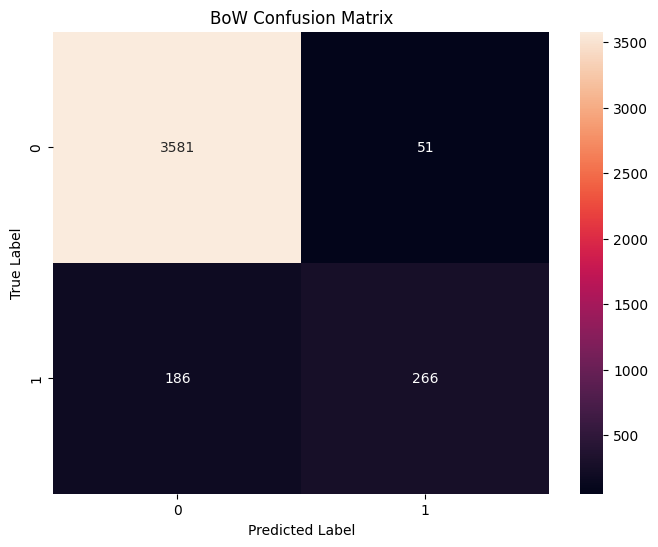

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

cm = confusion_matrix(labels_test, labels_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('BoW Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#SVM Model

In [ ]:
from sklearn.svm import SVC

# init/train SVM
svm = SVC(kernel='linear')
svm.fit(X_train, labels_train)

# prediction
labels_pred = svm.predict(X_test)

**Classification Report**

In [ ]:
accuracy = accuracy_score(labels_test, labels_pred)
print(f"SVM Model Accuracy: {accuracy}\n")
print(classification_report(labels_test, labels_pred))

SVM Model Accuracy: 0.9385406464250735

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3632
           1       0.79      0.61      0.69       452

    accuracy                           0.94      4084
   macro avg       0.87      0.79      0.83      4084
weighted avg       0.93      0.94      0.94      4084



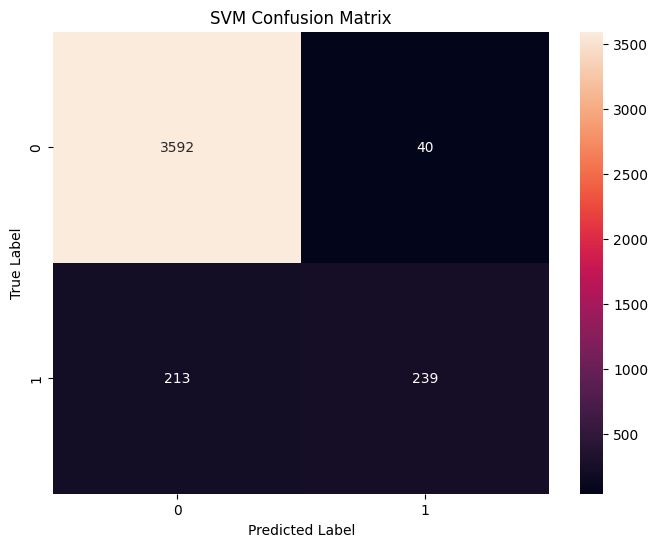

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

cm = confusion_matrix(labels_test, labels_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.metrics import classification_report

# correct data types for processing
labels_train = labels_train.astype('int')
labels_test = labels_test.astype(int)

# tokenizing and padding sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts_train)
X_train_seq = tokenizer.texts_to_sequences(texts_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=100)
X_train_padded = X_train_padded.astype('float32')

# CNN model, 10 epochs
def cnn_model(input_dim=5000, output_dim=50, input_length=100):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# training/assigning model to "cnn" for use in ensemble model
cnn = cnn_model()
cnn.fit(X_train_padded, labels_train, epochs=10, batch_size=10)

# preparing test data
X_test_seq = tokenizer.texts_to_sequences(texts_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)
X_test_padded = X_test_padded.astype('float32')

# predicting on test set
probabilities = cnn.predict(X_test_padded)
predicted_labels = (probabilities > 0.5).astype(int)

# classification report
report = classification_report(labels_test, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)

Epoch 1/10
1634/1634 [==============================] - 19s 11ms/step - loss: 0.2052 - accuracy: 0.9240
Epoch 2/10
1634/1634 [==============================] - 18s 11ms/step - loss: 0.1227 - accuracy: 0.9538
Epoch 3/10
1634/1634 [==============================] - 18s 11ms/step - loss: 0.0729 - accuracy: 0.9742
Epoch 4/10
1634/1634 [==============================] - 19s 11ms/step - loss: 0.0388 - accuracy: 0.9871
Epoch 5/10
1634/1634 [==============================] - 18s 11ms/step - loss: 0.0234 - accuracy: 0.9933
Epoch 6/10
1634/1634 [==============================] - 18s 11ms/step - loss: 0.0151 - accuracy: 0.9958
Epoch 7/10
1634/1634 [==============================] - 19s 12ms/step - loss: 0.0107 - accuracy: 0.9972
Epoch 8/10
1634/1634 [==============================] - 18s 11ms/step - loss: 0.0113 - accuracy: 0.9971
Epoch 9/10
1634/1634 [==============================] - 18s 11ms/step - loss: 0.0097 - accuracy: 0.9979
Epoch 10/10
128/128 [==============================] - 1s 10ms/s

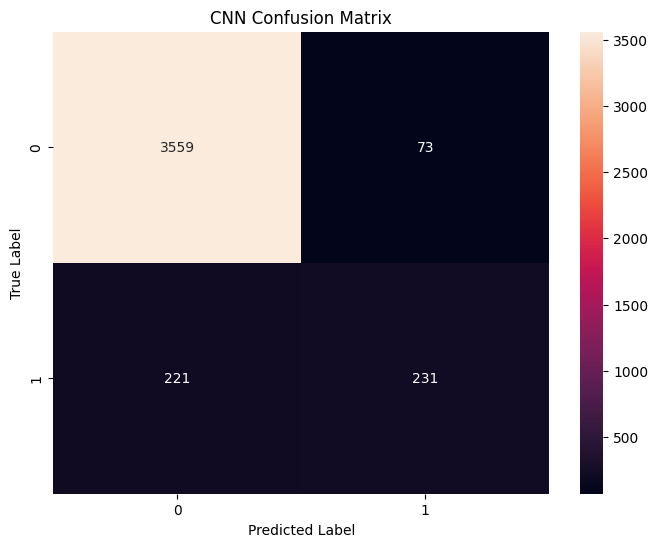

In [ ]:
cm = confusion_matrix(labels_test, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Overall slightly worse than our more simple Bag of Words (BoW) model based on the precision, recall, and f1 scores for Class 1 (unfair language).

These results surprised us because althogh convolutional neural networks are usually used for image processing, they are supposed to be good at adpating to detecting local patterns in language and its abstract aspects, in our case aspects unfair language. But as we see above, after 10 epochs the results are not as good as our BoW model.

The CNN's lower performance suggests that the local patterns of language in terms and conditions are not as important as the specific words used in terms of classifying as unfair or not.  

#Gradient Boosting Model

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# split data
texts_train, texts_test, labels_train, labels_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# vectorize
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(texts_train)
X_test_tfidf = vectorizer.transform(texts_test)

# label encoding
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)


In [ ]:
# init XGBoost classifier "gb"
gb = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=150,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# train gb
gb.fit(X_train_tfidf, labels_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# predict on test data
labels_pred_encoded = gb.predict(X_test_tfidf)

# get original labels from predictions
labels_pred = label_encoder.inverse_transform(labels_pred_encoded)

# classification report and confusion matrix
gb_accuracy = accuracy_score(labels_test, labels_pred)
print(f"GB Model Accuracy: {gb_accuracy}\n")
print(classification_report(labels_test, labels_pred))
print(confusion_matrix(labels_test, labels_pred))

GB Model Accuracy: 0.938050930460333

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3632
           1       0.86      0.53      0.65       452

    accuracy                           0.94      4084
   macro avg       0.90      0.76      0.81      4084
weighted avg       0.93      0.94      0.93      4084

[[3592   40]
 [ 213  239]]


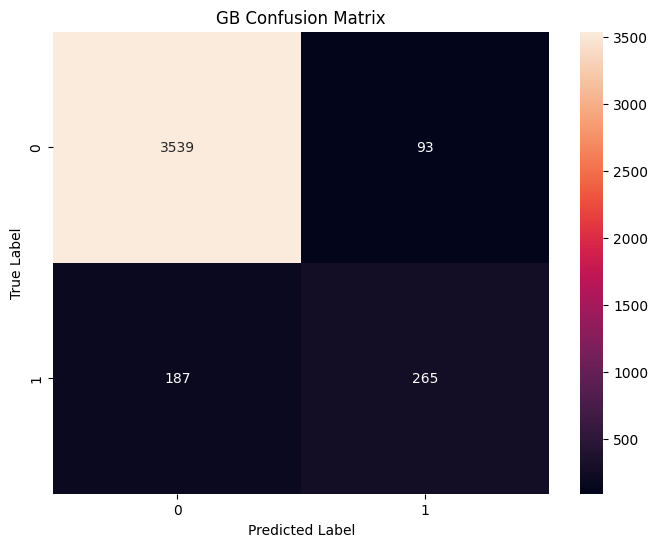

In [ ]:
labels_test = labels_test.astype(int)

cm = confusion_matrix(labels_test, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('GB Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#ENSEMBLE MODEL

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# voting among models
ensemble = VotingClassifier(estimators=[
    ('bow', cnn_model),
    ('svm', svm),
    ('cnn', bow),
    ('gb', gb)
], voting='hard')

ensemble.fit(X_train, labels_train)
ensemble_predictions = ensemble.predict(X_test)

# evaluating ensemble model
print("Accuracy:", accuracy_score(labels_test, ensemble_predictions))
print(classification_report(labels_test, ensemble_predictions))
print("Confusion Matrix:\n", confusion_matrix(labels_test, ensemble_predictions))

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'